# SIADS 593 - Milestone 1

*By: Aaron Dankert and Luis Gallego*

*Winter 2024*

# Introduction

#### Motivation and Background
Existing research rarely directly addresses aspiring data scientists seeking to strategically launch a career in this field and much of the relevant data and analysis is behind paywalls.1 Compounding the issue, the labor market for data science  related talent is undergoing perpetual turmoil – from rapidly evolving toolsets, the influx of talent from new education programs, and the digitization of economies.$^{2}$ The ‘Data Scientist’ occupation itself projected to see among largest changes in labor demand within the next decade.$^{3}$ We are using data from the largest industry surveys to shed light on broad labor market trends for data science talent that may prove actionable for navigating the momentous decisions in their immediate futures. 
One of the deficiencies of the available data is that it doesn’t use a common measure of compensation, challenging efforts to make inter-country comparisons. The standardization of the data for comparison offers the opportunity to do so by using Purchasing Power Parity (PPP). PPP allows for the comparison of economic indicators across countries in a way that reflects differences in price levels. By using PPP, salaries and other compensation figures can be adjusted to account for the cost of living in each country, enabling more accurate international comparisons. By presenting compensation data in PPP-adjusted terms, we can offer a clearer, more equitable view of global salary trends.
Thus an opportunity presented itself to use PPP adjustment to create more meaningful data from the industry surveys for further analysis

#### Objectives
Presenting PPP-adjusted data, metrics and analysis may offer aspiring data scientists clarity to make informed decisions about where to pursue opportunities, how to evaluate job offers, and what regions might offer the most promising economic benefits for their career growth. Furthermore, how might other features of the survey data interact with PPP adjusted compensation?
To reach this question and answer would be complex and time consuming. Given our data we discussed next we will attempt to answer further questions that can shine light on the overarching question:
- What do the distributions of observed salaries look like, and is there any skew?
- What insights can be provided on change in salaries per country and can we explain this?
- Do years of experience make a difference in salary while looking at the education levels of professionals?


## Limitations

Both SO and AI salary data sets are public, thus we have voluntary response bias. Most data professionals likely have not completed these surveys, so we are assuming and small sample. There may also be falsifications or data entry errors, there is no way of knowing either, so they are treated like outliers; there were some salary figures up to 7 figures USD. The SO data does not accurately reflect some countries on account of it being “inaccessible to prospective respondents in Crimea, Cuba, Iran, North Korea, and Syria, due to the traffic being blocked by our third-party survey software”.$^{6}$ The AI jobs data has a shorter list of features that lack demographic information compared to SO, and it was not included in the education analysis above. Lastly, the PPP and OECD data does not exist for all countries for all years, even in the time frame chosen. There is likely some meaningful bias on this account where these countries are susceptible to being excluded from data jobs.

# Installation

The python environment has been recorded in requirements.txt file. Use pip to install the packages enumerated in the file.

In [1]:
# !pip install -q -r requirements.txt

## Libraries

In [2]:
# Standard library imports
from collections import defaultdict
from typing import List, Tuple
import os
import warnings

# Third party imports
import altair as alt  # For declarative statistical visualization
import matplotlib.pyplot as plt  # For creating static, animated, and interactive visualizations
import numpy as np  # For numerical operations
import pandas as pd  # For data manipulation and analysis
import pycountry  # For country related utilities
import pingouin as pg  # For statistical analysis
import plotly.express as px  # For creating interactive plots
import scipy  # For scientific computing
import seaborn as sns  # For statistical data visualization
from scipy.stats import norm  # For normal continuous random variable

# Local application imports
from func_library import *  # Importing all functions from func_library module

warnings.filterwarnings('ignore') # To suppress warnings
pd.set_option('display.max_columns', 500) # To display all columns
np.random.seed(42) # For reproducibility
alt.data_transformers.enable('vegafusion') # For enabling altair data transformer and handling large datasets

DataTransformerRegistry.enable('vegafusion')

# Data Cleaning and Manipulation

Processing and feature generation is done using a collection of functions and constant variables defined in func_library.py This is to keep the functions provide additional context via their organization in that file and to modularize sub routines from this project to facitilitate further exploration or export to other, related projects.

# Load Data

In [3]:
stack_overflow, skills_list, employments = StackOverflowData.generate_aggregate_df(only_data_science_devs=True)
exchange_rate_df = generate_exchange_rates_df()
ppp_df = read_ppp()
stack_overflow = StackOverflowData.generate_2023_usd_comp(stack_overflow, exchange_rate_df, ppp_df)

ai_salaries_df = AISalariesData.generate_df()
ai_salaries_df = AISalariesData.generate_2023_usd_comp(ai_salaries_df, exchange_rate_df, ppp_df)
ai_salaries_df = pd.concat([ai_salaries_df, pd.get_dummies(ai_salaries_df["job_title"], dtype='int')], axis=1)
ai_salaries_df = ai_salaries_df.drop("job_title", axis=1)

ai_salaries_df = ai_salaries_df.dropna(subset=['usd_2023'])
stack_overflow = stack_overflow.dropna(subset=['usd_2023'])

# copies of the original dataframes for charts that need a smaller set of features
stack_overflow_chart_df = stack_overflow.copy()
ai_salaries_chart_df = ai_salaries_df.copy()

In [4]:
# prevent outliers for our purposes for this data frame
relevant_skills = [skill for skill in skills_list if "hww" in skill]
stack_overflow["total_skills"] = stack_overflow[relevant_skills].sum(axis=1)
q3 = stack_overflow["usd_2023"].quantile(0.75)
IQR = stack_overflow["usd_2023"].quantile(0.75) - stack_overflow["usd_2023"].quantile(0.25)
stack_overflow = stack_overflow[stack_overflow["usd_2023"] < q3 + (1.5*IQR)]

s_o = stack_overflow.drop(skills_list, axis=1)

# important otherwise we get lots of categorical variables later on
s_o["edlevel"] = s_o["edlevel"].replace({
    "Some College": "<=Bachelor's",
    "Associate's": "<=Bachelor's",
    "Secondary": "<=Bachelor's",
    "Elementary": "<=Bachelor's",
    "Else": "<=Bachelor's",
    "Bachelor's": "<=Bachelor's"
})

# also for our purposes we need to standardize this to integers
s_o["yearscodepro"] = s_o["yearscodepro"].replace({'Less than 1 year': 0, 'More than 50 years': 50})
s_o["yearscodepro"] = s_o["yearscodepro"].fillna(0)
s_o["yearscodepro"] = s_o["yearscodepro"].astype(int)
s_o["experience_level"] = pd.cut(
                                x=s_o["yearscodepro"], 
                                bins=[0, 2, 5, 10, np.inf],
                                labels=['Entry', 'Middle', 'Senior', 'Executive']
                            )

## Combine

In [5]:
# make sure the columns are equal so that we can vertically concatenate
temp_so = s_o[["year", "experience_level", "country", "usd_2023"] + list(employments)]
temp_ai = ai_salaries_df[["work_year", "experience_level", "employee_residence", "usd_2023"] + list(employments)]
temp_ai.columns = temp_so.columns

# concatenate
merged = pd.concat([temp_so, temp_ai], axis=0, ignore_index=True)

# get rid of outliers
IQR = merged["usd_2023"].quantile(0.75) - merged["usd_2023"].quantile(0.25)
q3 = merged["usd_2023"].quantile(0.75)

# curious about number of outliers
outliers = merged[merged['usd_2023'] > q3 + (1.5*IQR)]
print(f"Outliers: {len(outliers)} vs. Normal: {len(merged)}")

# now get rid of outliers
merged = merged[merged['usd_2023'] < q3 + (1.5*IQR)]

# final data manipulation, these were strings and below were abbreviations initially
merged.loc[:, "year"] = merged.loc[:, "year"].astype('int64')
merged["experience_level"] = merged["experience_level"].replace({'SE': 'Senior', 'MI': 'Middle', 'EN': 'Entry', 'EX': 'Executive'})

Outliers: 589 vs. Normal: 53158


# Analysis
### Helper Functions and Data maps

In [6]:
# create map for ISO 3166-1 alpha-2 to country name
alpha2_to_name = {country.alpha_2: country.name for country in pycountry.countries}


def generate_stacked_barchart(merged, countries):
    """
    Generate a stacked bar chart for the number of statistically significant differences
    among countries.
    :param merged: the merged data frame
    :param countries: the countries we want to compare
    :return: None
    """
    groupped = merged.groupby("year")
    dfs = []
    for year, frame in groupped:
        t_tests = np.zeros((len(countries), len(countries)))
        frame = frame[frame["country"].isin(countries)]
        for i in range(len(countries)):
            control = countries[i]
            for j in range(i+1, len(countries)):
                exp = countries[j]
                d1 = frame[frame["country"] == control]
                d2 = frame[frame["country"] == exp]
                result = pg.ttest(d1.usd_2023, d2.usd_2023).round(3) # this is 2 tailed
                t_tests[j, i] = result.loc["T-test", "p-val"]
        df = pd.DataFrame(t_tests, columns=countries, index=countries)
        dfs.append(df)

    # Create a dictionary to store the counts of statistically significant differences    
    stat_counts = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: 0)))
    year = 2019
    for df in dfs:
        for start in range(len(df)):
            r = start
            c = 0
            dec_row = False
            while c < len(df) and r < len(df):
                if r == c: # then we are on the diagonal
                    dec_row = True
                    r += 1
                    continue
    
                row = df.index[r]
                col = df.columns[c]
                if df.iloc[r, c] < 0.05:
                    val = 1
                else:
                    val = 0
                        
                if not dec_row: # we are going across
                    stat_counts[str(year)][row][col] = val
                    c += 1
                else:
                    stat_counts[str(year)][col][row] = val
                    r += 1
        year += 1
    result = {}
    for year, count_dict in stat_counts.items():
        counts = [] 
        for key, value in count_dict.items():
            counts.append((key, sum(value.values())))
        result[year] = counts
    
    # Transform the data to a format that can be used to create a DataFrame
    transformed_data = {}
    for key, tuples in result.items():
        for tup in tuples:
            index, value = tup[0], tup[1]
            if index not in transformed_data:
                transformed_data[index] = {}
            transformed_data[index][key] = value
    
    # Create DataFrame from transformed data
    working = pd.DataFrame.from_dict(transformed_data, orient='index')
    working["total"] = working[["2019", "2020", "2021", "2022", "2023"]].sum(axis=1)
    working = working.sort_values("total", ascending=False)
    
    # Create the stacked bar chart
    fig, ax = plt.subplots(figsize=(15, 8))
    working.index = [alpha2_to_name[country] for country in working.index]
    working[["2019", "2020", "2021", "2022", "2023"]].plot(kind="barh", stacked=True, ax=ax)
    ax.set_title("Number of Statistically Significant Differences Among Countries")
    ax.set_xlabel('count')
    
    # Add labels to the bars
    # https://www.pythoncharts.com/matplotlib/stacked-bar-charts-labels/
    y_offset = -0.4
    for bar in ax.patches:
      ax.text(
          bar.get_x() + bar.get_width() / 2,
          bar.get_height() + bar.get_y() + y_offset,
          round(bar.get_width()),
          ha='center',
          color='k',
          size=9
      )
    
    plt.show()


In [7]:
# Add a 'Source' column to each dataframe
ai_salaries_chart_df['source'] = 'AI-jobs.net'
stack_overflow_chart_df['source'] = 'StackOverflow'
ai_salaries_chart_df['country'] = ai_salaries_chart_df['company_location']

# change all work_year values to strings; rename to 'year'
ai_salaries_chart_df['work_year'] = ai_salaries_chart_df['work_year'].astype(str)
ai_salaries_chart_df['year'] = ai_salaries_chart_df['work_year']
combined_chart_df = pd.concat([ai_salaries_chart_df[['usd_2023', 'source', 'country', 'year']], stack_overflow_chart_df[['usd_2023', 'source', 'country', 'year']]])

# eliminate outliers from the combined dataframe
combined_chart_q3 = combined_chart_df['usd_2023'].quantile(0.75)
combined_chart_q1 = combined_chart_df['usd_2023'].quantile(0.25)
combined_iqr = combined_chart_q3 - combined_chart_q1
combined_lower_bound = combined_chart_q1 - (1.5 * combined_iqr)
combined_upper_bound = combined_chart_q3 + (1.5 * combined_iqr)
combined_chart_df = combined_chart_df[(combined_chart_df['usd_2023'] > combined_lower_bound) & (combined_chart_df['usd_2023'] < combined_upper_bound)]

# process the combined chart dataframe
countries = get_similar_countries(merged, 20)

# now we sort the countries by overall averages for later use
sort = merged[merged["country"].isin(countries)].groupby("country")["usd_2023"].mean().sort_values()
countries = list(sort.index)

## Distribution of standardized salary observations in each salary dataset.

In [8]:
def layered_distribution_chart(chart_df: pd.DataFrame):
    """
    This function creates a layered distribution chart using Altair to compare the distributions of standardized
    compensation data from the StackOverflow and AI-jobs.net datasets.
    :param chart_df: The combined chart dataframe
    """
    
    background_color = COLOR_THEME['background']

    bar_colors = {
        'AI-jobs.net': COLOR_THEME['secondary'],
        'StackOverflow': COLOR_THEME['primary']
    }

    chart = alt.Chart(chart_df.sort_values(by=['source'], ascending=False)).mark_bar(opacity=1,
                                                                                        binSpacing=0.3,
                                                                                        cornerRadiusTopLeft=4,
                                                                                        cornerRadiusTopRight=4).encode(
        alt.X('usd_2023:Q', bin=alt.Bin(maxbins=50), title='USD 2023 Salary'),
        alt.Y('count()', stack=None, title='Count'),
        alt.Color('source:N', legend=alt.Legend(title="Dataset", orient='top-right', 
                                                fillColor=background_color, labelColor=COLOR_THEME['text'], 
                                                titleColor=COLOR_THEME['text'], titlePadding=5, 
                                                labelLimit=200, padding=5), 
                scale=alt.Scale(domain=list(bar_colors.keys()), range=list(bar_colors.values()))),
    ).properties(
        width=600,
        height=400,
        title="Salary Distribution Comparison",
        background=background_color
    ).configure_view(
        stroke=background_color,
        fill=background_color
    ).configure_axis(
        labelColor=COLOR_THEME['text'],
        titleColor=COLOR_THEME['text']
    )
    return chart

dist_chart = layered_distribution_chart(combined_chart_df)
dist_chart.display()

alt.Chart(...)

This chart demonstrates a fundamental issue combining these datasets -- that they do not share the same distribution and therefore could not be representative of the same population. A violation of an assumption that is important to be cognisent of.

## Mean Compensation Estimates for Represented Countries

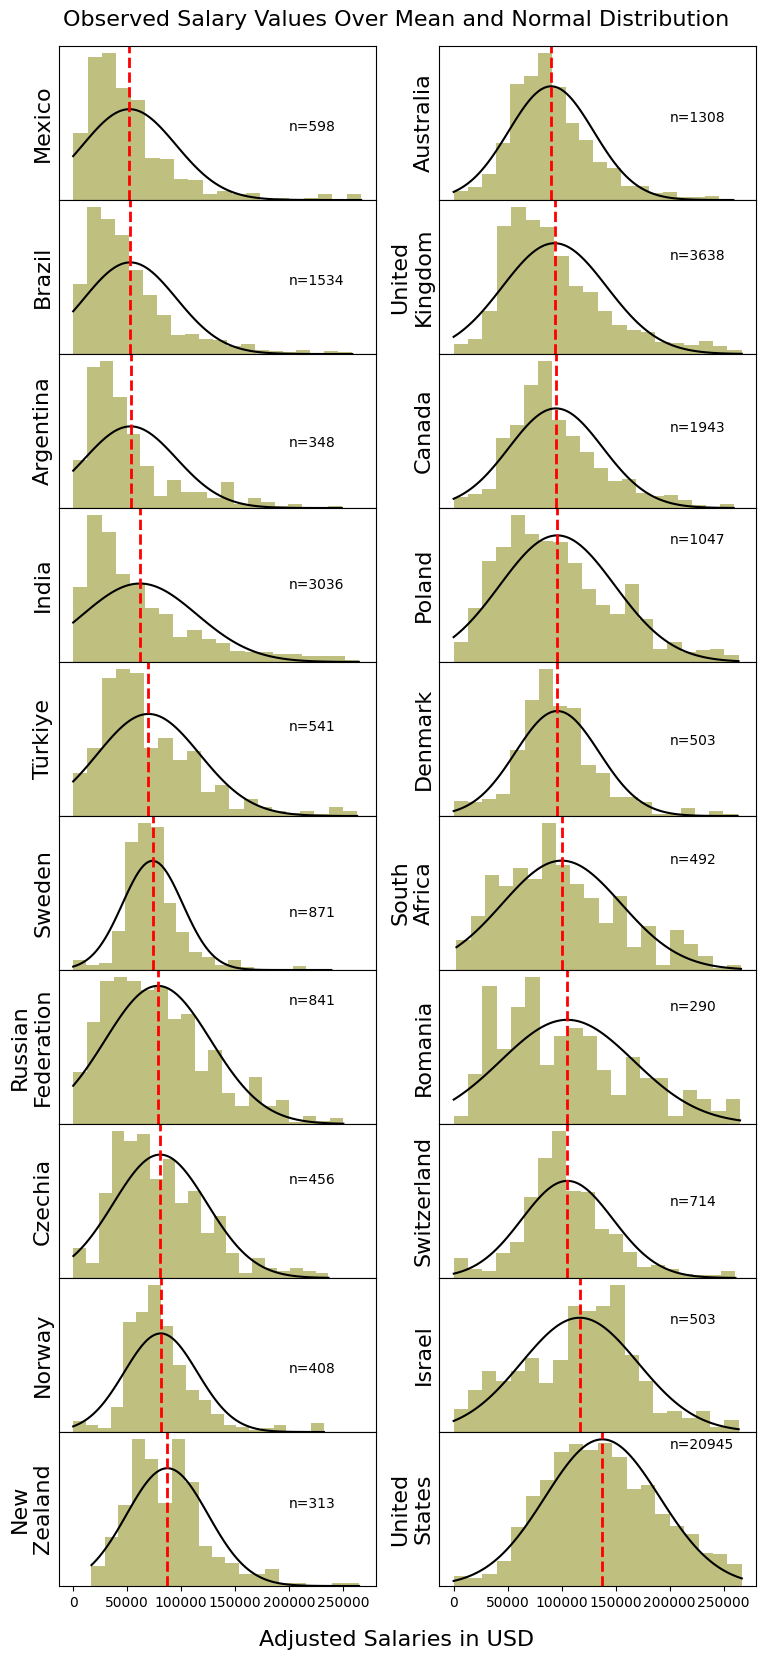

In [9]:
first_half = countries[:len(countries)//2]
second_half = countries[len(countries)//2:]
length = max(len(first_half), len(second_half))

fig, axes = plt.subplots(length, 2, sharex=True, figsize=(9, 20))

# iterate over the axes and the countries
for i in range(length):
    working = merged[merged["country"] == first_half[i]]
    mean_value = working["usd_2023"].mean()
    
    param = norm.fit(working["usd_2023"]) # distribution fitting
    x = np.linspace(working["usd_2023"].min(), working["usd_2023"].max(), 100)
    pdf_fitted = norm.pdf(x, *param)   
    
    axes[i, 0].plot(x, pdf_fitted, color='black', label="Normal distribution")
    axes[i, 0].axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label='Mean')
    axes[i, 0].hist(working["usd_2023"], bins=20, alpha=0.5, density=True, label="Actual distribution", color='olive')
    axes[i, 0].set_yticks([])
    axes[i, 0].set_ylabel("\n".join(alpha2_to_name[first_half[i]].split(" ")), fontsize=16)
    axes[i, 0].text(200000, 7e-6, f"n={len(working)}")

    working = merged[merged["country"] == second_half[i]]
    mean_value = working["usd_2023"].mean()
    
    param = norm.fit(working["usd_2023"])
    x = np.linspace(working["usd_2023"].min(), working["usd_2023"].max(), 100)
    pdf_fitted = norm.pdf(x, *param)   
    
    axes[i, 1].plot(x, pdf_fitted, color='black', label="Normal distribution")
    axes[i, 1].axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label='Mean')
    axes[i, 1].hist(working["usd_2023"], bins=20, alpha=0.5, density=True, label="Actual distribution", color='olive')
    axes[i, 1].set_yticks([])
    axes[i, 1].set_ylabel("\n".join(alpha2_to_name[second_half[i]].split(" ")), fontsize=16)
    axes[i, 1].text(200000, 7e-6, f"n={len(working)}")

fig.text(0.5, 0.08, 'Adjusted Salaries in USD', ha='center', fontsize=16)
fig.text(0.5, 0.89, 'Observed Salary Values Over Mean and Normal Distribution', ha='center', fontsize=16)

plt.subplots_adjust(hspace=0)
plt.show()

Above we have the actual distributions in olive with the normal overlayed in black; the mean salary from 2019-2023 is in a dashed red line. We can see that the chart reads from top to bottom, and once at the bottom to the right then top to bottom again. It can be seen that very large samples, like in the US, result in an almost normal distribution, while smaller values are skewed right, like in Romania. An exception to this is India where it it heavily skewed right, as opposed to the Great Britain which has a comparable number of responses.

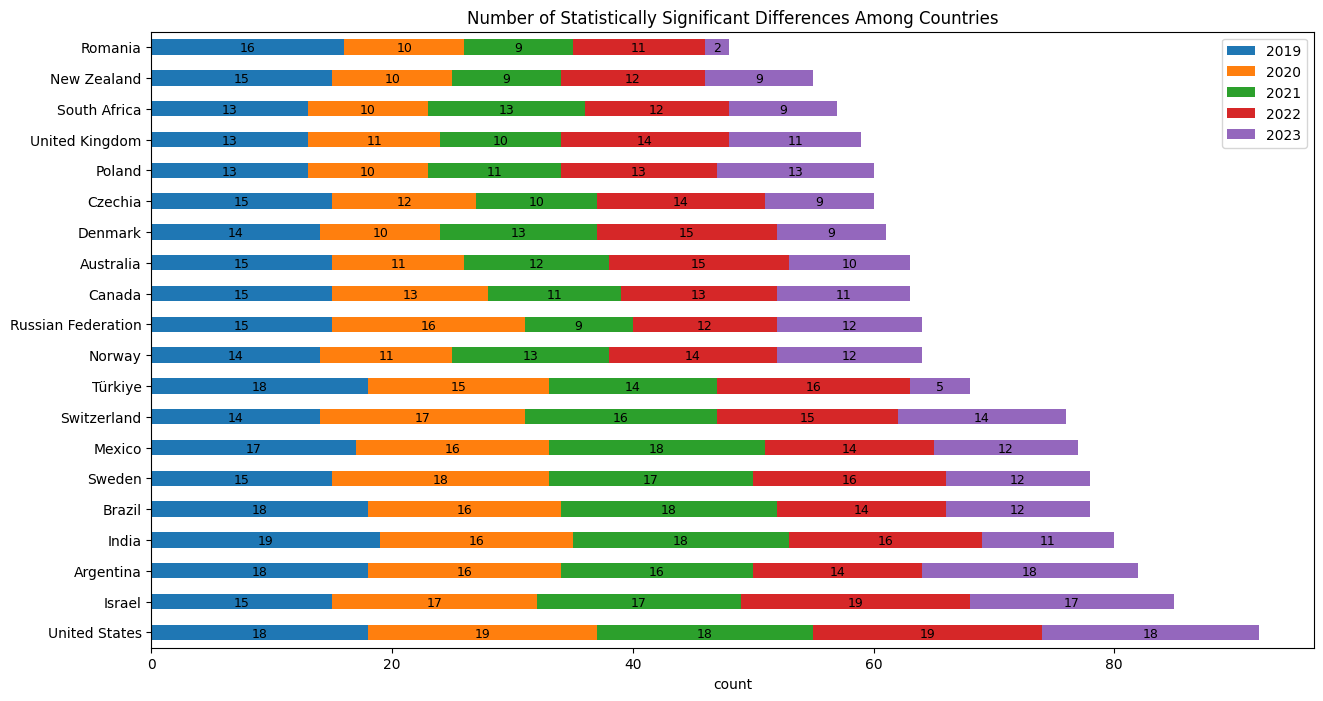

In [10]:
generate_stacked_barchart(merged, countries)

This bar chart, is complicated in the sense that the higher the number the more statistically significant differences there are. T-tests were done on each combination and this bar chart was created after ordering the total number of differences. Year is encoded by color. Unsurprisingly, the US was at the top, likely because of it's high salaires, and so was India and Brazil even more surprisingly. If we take a look at some of these means.

In [11]:
for c in countries:
    print(f"{c} mean: ${merged[merged['country'] == c]['usd_2023'].mean()}")

MX mean: $52083.77108290236
BR mean: $52872.06399910461
AR mean: $53207.20330396543
IN mean: $61794.927661680595
TR mean: $69760.527087333
SE mean: $73512.68346795124
RU mean: $78470.96430112082
CZ mean: $80593.48206995855
NO mean: $81110.80221203179
NZ mean: $87176.07756011485
AU mean: $90280.45016153266
GB mean: $93445.7249197411
CA mean: $94690.95767361698
PL mean: $95937.44855105618
DK mean: $96020.04283997793
ZA mean: $100098.83155691
RO mean: $105186.19248057486
CH mean: $105321.66627248378
IL mean: $116717.77724709858
US mean: $137757.56853992204


Now we get a more definitive look as to why the US and Israel have such big differences. While Romania does not despite having a comparable overall mean. Looking at the first figure we see that Romania has a sample of 290 vs the US of more than 20,000. This factors into the equation of the t-test where the standard deviation is divided by the sample size (n). Large values of n mean that deviations from the null hypothesis (that both populations have the same mean) have a statistical effect than smalle samples do, or that's it's less uncertain the smaller the sample size. It's likely that given this fact and Romania's distribution, that when compared to other small sampled countries that the effects described earlier are smaller than than when compared to the US's.

We see the same with India as the sample size is much larger than othe countries.

## Percent Changes in Countries Per Year

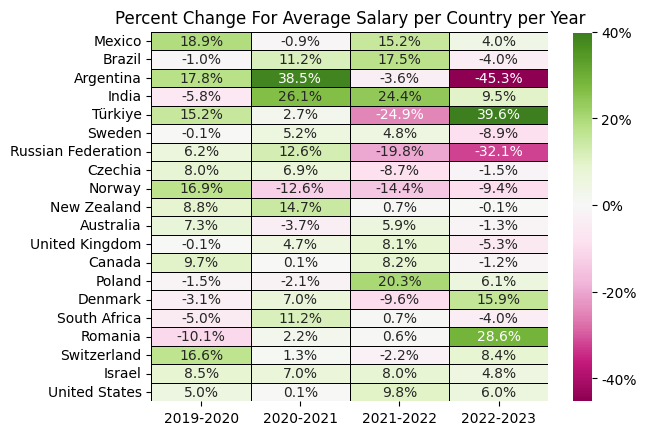

In [12]:

pivot = pd.pivot_table(merged, values="usd_2023", index="country", columns="year", aggfunc="mean")
pivot = pivot.dropna()

pivot = pivot.loc[countries, :]
pivot = pivot.pct_change(axis=1)
pivot.columns = ["2019"] + [f"{int(year)-1}-{year}" for year in pivot.columns[1:]]
pivot = pivot.drop("2019", axis=1)
pivot.index = [alpha2_to_name[country] for country in pivot.index]

plt.title("Percent Change For Average Salary per Country per Year")
ax = sns.heatmap(pivot, annot=True, center=0, fmt="0.01%", cmap="PiYG", linecolor='k', linewidths=0.5)
cbar = ax.collections[0].colorbar
cbar.set_ticks([-0.4,  -0.2, 0, 0.2, 0.4])
cbar.set_ticklabels(['-40%', '-20%', '0%', '20%', '40%'])
plt.show()

A deeper dive into the changer per year instead of the overall 2019-2023 gives us more actinable insights. This allows data professionals to see where their skills are most valued and where there is volatility. It can be seen that Argentina and Russia have the most volatility with their salaries. These relatively large increases with salary may not have to do with the skills that data professionals but rather with the volatile economies of these countries.

Russia invaded Ukraine in these years and as a result we see the sharp decreases in salary as their economy collapsed. Argentina on the other hand has been under economic distress and saw growth in salaries the last year it saw GDP growth. 

In [13]:
relevant_skills = [skill for skill in skills_list if "hww" in skill]
stack_overflow["total_skills"] = stack_overflow[relevant_skills].sum(axis=1)

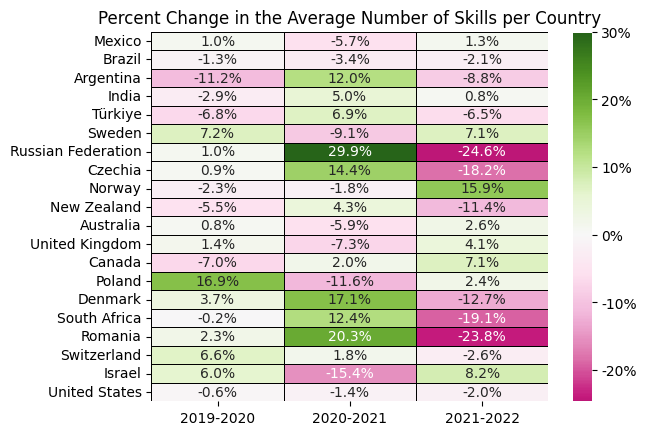

In [14]:
pivot = pd.pivot_table(stack_overflow, values="total_skills", index="country", columns="year", aggfunc="mean")
pivot = pivot.dropna()
pivot = pivot.loc[countries, :]
pivot = pivot.pct_change(axis=1)
pivot.columns = ["2019"] + [f"{int(year)-1}-{year}" for year in pivot.columns[1:]]
pivot = pivot.drop(["2019", "2022-2023"], axis=1)
pivot.index = [alpha2_to_name[country] for country in pivot.index]

plt.title("Percent Change in the Average Number of Skills per Country")
ax = sns.heatmap(pivot, annot=True, center=0, fmt="0.01%", cmap="PiYG", linecolor='k', linewidths=0.5)
cbar = ax.collections[0].colorbar
cbar.set_ticks([-0.2, -0.10, 0, 0.1, 0.2, 0.3])
cbar.set_ticklabels(['-20%', '-10%', '0%', '10%', '20%', '30%'])
plt.show()

This heatmap and the ones below did not make it into our slides due to space constraints. But we can still extract insights here. We see that ordering by the overall means still holds here, so we can see how skills change over time. Above we created the `total_skills` column in the `stack_overflow` data frame for use to get this pivot table turned into a heat map. We see a decline in skills in the US, likely because of the growth in low or no code options over the recent years that the StackOverflow survey did not cover. We also see that any relatively large increase in skills comes with its own sharp decrease from that year, notably in Romania and Russia. This could be due to sampling bias or the invasion of Ukraine in Russia's case. Sampling bias is hypothesized because 2023 is not included in this chart. This is because we get sharp decreases across all countries due to the size. Below it can be seen.

In [15]:
stack_overflow.groupby('year')['count'].count()

year
2019    15436
2020    10306
2021     8686
2022     6410
2023     2330
Name: count, dtype: int64

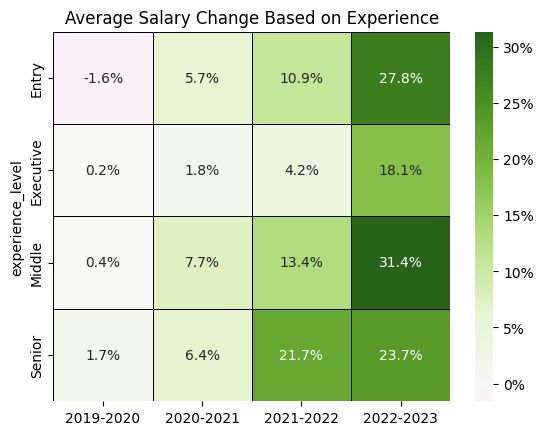

In [16]:
pivot = pd.pivot_table(merged, values="usd_2023", index="experience_level", columns="year", aggfunc="mean")
pivot = pivot.dropna()
# pivot = pivot[pivot["country"].isin(countries)]
# pivot = pivot.loc[countries, :]
pivot = pivot.pct_change(axis=1)
pivot.columns = ["2019"] + [f"{int(year)-1}-{year}" for year in pivot.columns[1:]]
pivot = pivot.drop("2019", axis=1)
plt.title("Average Salary Change Based on Experience")
ax = sns.heatmap(pivot, annot=True, center=0, fmt="0.01%", cmap="PiYG", linecolor='k', linewidths=0.5)
cbar = ax.collections[0].colorbar
cbar.set_ticks([0.0, 0.05, 0.1, 0.15, 0.20, 0.25, 0.3])
cbar.set_ticklabels(['0%', '5%', '10%', '15%', '20%', '25%', '30%'])
plt.show()

Even further we can granularize the merged salary data into their respective salary change based on experience. The stack overflow data required binning the years of experience, which were integers, into categories, which were named into what is seen here and is as follows:
- 0-2 years = entry
- 2-5 years = middle
- 5-10 years = senior
- +10 years = executive

Worldwide we see enormous growths in salary across all experience levels., especially among the middle level data professionals.

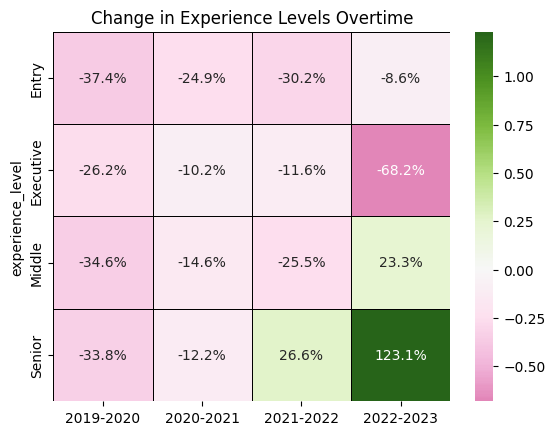

In [17]:
pivot = pd.pivot_table(merged, values="usd_2023", index="experience_level", columns="year", aggfunc="count")
pivot = pivot.dropna()
pivot = pivot.pct_change(axis=1)
pivot.columns = ["2019"] + [f"{int(year)-1}-{year}" for year in pivot.columns[1:]]
pivot = pivot.drop("2019", axis=1)

plt.title("Change in Experience Levels Overtime")
sns.heatmap(pivot, annot=True, center=0, fmt="0.01%", cmap="PiYG", linecolor='k', linewidths=0.5);

Counting the number of experience levels and getting the percent change nets us the complete opposite of what is above. Mostly we see drops in the number of these experience levels. This is counter intuitive since with less people in these categories we see a much larger increase in salaries. We can say that the salaries are increasing for entry level and executive positions, while the number of these positions, or people who hold them, are decreasing. Decreasing due to not wanting the job any more or switching careers is unsure. Stranger so, it's seen that the senior level has a dramatic increase of more than doubling between 2022-2023.

This chart does not capture any changes of individuals incrementing their experience level, and would be impossible given we don't have personal data, and it would be unethical for this analysis, since it's not needed.

## Levels of Degree and Experience

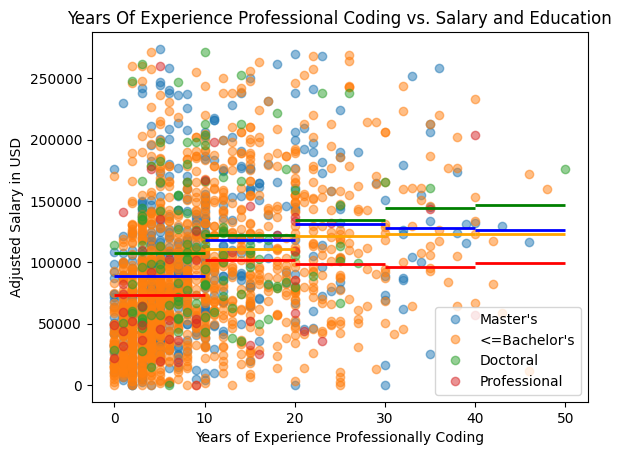

In [18]:
edu = s_o[~s_o["edlevel"].isin(['nan'])]
knots = [0, 10, 20, 30, 40, 50]
colors = {"Master's": "blue", "<=Bachelor's": "orange", "Doctoral": "green", "Professional": "red"}
for school in edu["edlevel"].unique():
    temp = edu[edu["edlevel"] == school].sample(frac=0.05)
    x = temp["yearscodepro"]
    y = temp["usd_2023"]
    plt.plot(x, y, 'o', label=school, alpha=0.5)
    for j in range(1, len(knots)):
        gt = knots[j-1]
        lt = knots[j]
        grouped = edu[edu["yearscodepro"].between(gt, lt)].groupby('edlevel')["usd_2023"].mean()
        plt.hlines(grouped[school], xmin=lt, xmax=gt, color=colors[school], zorder=5, linewidth=2)

plt.title("Years Of Experience Professional Coding vs. Salary and Education")
plt.xlabel("Years of Experience Professionally Coding")
plt.ylabel("Adjusted Salary in USD")
plt.legend(loc="best")
plt.show()

Though a noisy chart, this is the sampled version from the code snippet above. Otherwise, this would be incredibly noisy. The mark bars are the mean for this education level, where anythin less than a bachelor's is grouped together, which is also why it's the largest group. Doctoral degrees dominate the salary to no surprise due to the rigor of this degree. The education salary data is as expected following doctoral degrees, then masters, then bachelor's or less. Surprisingly, professional education last. Professional education is surprisingly in this data, which can include doctors and those who completed law school. These respondents have the lowest salary, consistently. Likely due to their education not being in a computer focused curriculum, and they switched to some sort of data profession. Or they may happen to code in their free time and use StackOverflow.

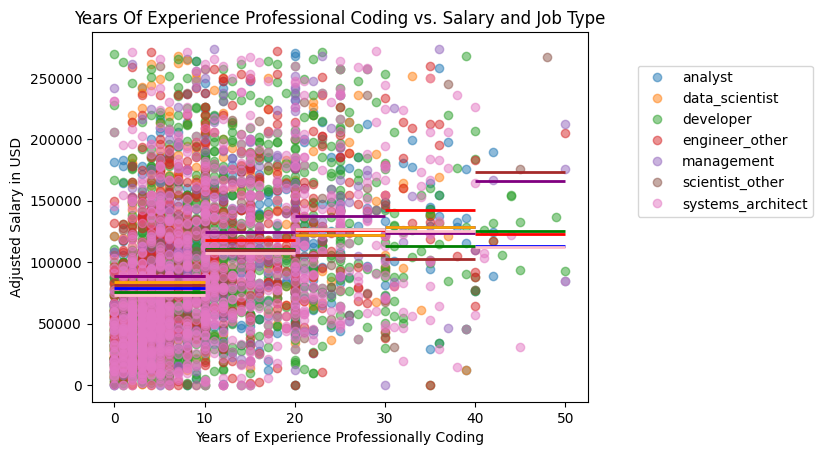

In [19]:
knots = [0, 10, 20, 30, 40, 50]
colors = {
    "analyst": "blue", 
    "data_scientist": "orange", 
    "developer": "green", 
    "engineer_other": "red", 
    "management": "purple", 
    "scientist_other": "brown", 
    "systems_architect": "pink"
}
for job in employments:
    temp = s_o[s_o[job] == 1].sample(frac=0.05)
    x = temp["yearscodepro"]
    y = temp["usd_2023"]
    plt.plot(x, y, 'o', label=job, alpha=0.5)
    for j in range(1, len(knots)):
        gt = knots[j-1]
        lt = knots[j]
        grouped = temp[temp["yearscodepro"].between(gt, lt)]["usd_2023"].mean()
        plt.hlines(grouped, xmin=lt, xmax=gt, color=colors[job], zorder=5, linewidth=2)

plt.title("Years Of Experience Professional Coding vs. Salary and Job Type")
plt.xlabel("Years of Experience Professionally Coding")
plt.ylabel("Adjusted Salary in USD")
plt.legend(loc=(1.1, 0.5))
plt.show()

Machine learning engineers and other kinds of engineers were grouped into the engineer_other category. We see that early in the career that engineers dominate, then as time goes on we see data scientists dominating the salaries with engineers. This is likely to the boom in data scientists resulting in more people with experience to mentor those within the workplace. Analysts are lower on the average salary for our time ranges, as well as system architects. This is strange considering how closely an analysts job is with a data scientists, as well as the need for cloud and system architects in a growing digital world.

## Choropleth of % Changes in Standardized Compensation


In [20]:
def choropleth_of_deltas(choro_chart_df: pd.DataFrame) -> alt.Chart:
    df_2019 = choro_chart_df[choro_chart_df['year'] == '2019'] 
    df_2023 = choro_chart_df[choro_chart_df['year'] == '2023']

    # Only keep countries with 10+ observations
    country_counts_2019 = df_2019.country.value_counts()
    country_counts_2023 = df_2023.country.value_counts()
    valid_countries = country_counts_2019[country_counts_2019 >= 10].index.intersection(
                        country_counts_2023[country_counts_2023 >= 10].index)

    df_2019 = df_2019[df_2019['country'].isin(valid_countries)]
    df_2023 = df_2023[df_2023['country'].isin(valid_countries)]

    # Calculate averages for each country and year
    df_2019 = df_2019.groupby('country')['usd_2023'].mean().reset_index()
    df_2023 = df_2023.groupby('country')['usd_2023'].mean().reset_index()

    # Merge and calculate deltas
    change_19_23_df = df_2019.merge(df_2023, on='country')
    change_19_23_df['delta'] = change_19_23_df['usd_2023_y'] - change_19_23_df['usd_2023_x']
    change_19_23_df['pct_change'] = change_19_23_df['delta'] / change_19_23_df['usd_2023_x'] * 100
    change_19_23_df = change_19_23_df[['country', 'usd_2023_x', 'usd_2023_y', 'delta', 'pct_change']]
    change_19_23_df.columns = ['country', '2019_comp', '2023_comp', 'delt', 'percent_change']

    #from vega_datasets import data
    change_19_23_df['country_alpha_3'] = change_19_23_df['country'].apply(lambda x: convert_country_alpha2_to_alpha3(x))

    # Create the choropleth map with Plotly Express
    fig = px.choropleth(change_19_23_df,
                        locations='country_alpha_3',
                        color='percent_change',
                        hover_name='country_alpha_3',
                        color_continuous_scale=[COLOR_THEME['bold'], 'lightgrey', COLOR_THEME['secondary']],
                        color_continuous_midpoint=0)

    fig.update_geos(
        landcolor=COLOR_THEME['alt_background'],  # Neutral color for land
        lakecolor=COLOR_THEME['primary'],  # Color for lakes
        oceancolor=COLOR_THEME['primary'],  # Color for ocean
        showocean=True,
        showcountries=True # Show country borders
    )

    fig.update_layout(
        paper_bgcolor=COLOR_THEME['alt_background'],
        plot_bgcolor=COLOR_THEME['alt_background'],
        title_font_color=COLOR_THEME['text'],
        font_color=COLOR_THEME['text'],
        geo=dict(
            bgcolor=COLOR_THEME['alt_background'],
            showframe=False,
            showcoastlines=False,
            projection_scale=1.1,
            center=dict(lat=30, lon=0), # change the center of the map
        ),
        margin=dict(l=0, r=0, t=0, b=0)  # Minimize margins around the map
    )

    fig.update_coloraxes(colorbar=dict(
        title=r'Net % change in average salary 2019-2023',
        titleside='right',
        titlefont=dict(size=12, color=COLOR_THEME['text']),
        tickfont=dict(color=COLOR_THEME['text']),
        bgcolor=COLOR_THEME['alt_background'],
        len= 0.8,
        y=.42
    ))
    return fig

choro_chart = choropleth_of_deltas(combined_chart_df)
choro_chart.show()

This figure illustrates the percentage change in compensation for data professionals from 2019 to 2023. Countries are color-coded to reflect increases or decreases in salary, offering a clear, visual representation of global compensation trends. The gradations of color from light to dark indicate the range of percentage changes, with the scale provided for precise interpretation. The countries not encoded with colors from the scale were not included in the visualization because they did not have sufficient number of observations to be considered representative if they had any at all.
Here we observe that compensation in China, India, and Colombia have been on tear recently. China has seen improvements of ~76%, India has grown it’s data professionals’ mean compensation by 60%, whereas Colombia saw its data professional salaries double in those four years. Recall these movements have been controlled for changes in purchasing power and are genuine increases in genuine increases in the standard of living for these professionals. 
Among the unhappiest data professional have to be those residing in Russia where compensation has fallen ~36%. Russian workers have been impacted by the sanctions imposed for their incursion into Ukraine.$^{4}$ This is not a viable excuse for other countries’ atrophying compensation packages. Vietnam saw its data professionals lose 42% of their purchasing ability. Norway also saw a plunge in compensation of ~21%.
Emerging data professionals can leverage this map to strategically plan the launch of their careers by identifying geographic regions with robust growth in compensation. Considering the upward trends in countries like China, India, and Colombia, these locations may offer promising opportunities for personal and professional development. Conversely, awareness of regions with declining compensation, such as Russia and Vietnam, is crucial for career risk management. 


# References
1. Coresignal. (2024, February 15). Always Fresh Public Web Data. Retrieved from https://coresignal.com/
2. U.S. Bureau of Labor Statistics. (2023, September 6). Data scientists. Occupational Outlook Handbook. Retrieved from https://www.bls.gov/ooh/math/data-scientists.htm
3. OECD. (2019). Digitalisation and productivity. Retrieved from https://www.oecd.org/economy/growth/digitalisation-productivity-and-inclusiveness/
4. Lambertucci, C. (2023, November 18). The daunting economic landscape choking Argentine voters. El Pais. Retrieved from https://english.elpais.com/international/2023-11-18/the-daunting-economic-landscape-choking-argentine-voters.html
5. Lindsay, J. M. (2020, December 17). Ten most significant world events in 2020. Council on Foreign Relations. Retrieved from https://www.cfr.org/blog/ten-most-significant-world-events-2020
6. Reuters. (2022, April 14). Russian workers face new reality as Ukraine war sanctions sap job prospects. Retrieved from https://www.reuters.com/business/russian-workers-face-new-reality-ukraine-war-sanctions-sap-job-prospects-2022-04-13/
7. Stack Overflow. (2023). StackOverflow Developer Survey 2023. Retrieved from https://survey.stackoverflow.co/2023/#methodology-general

\* Some references only used in accompanying report